# Computational Language Technology Stage 1

#### Load the data

In [1]:
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import re

# 1. Load the data
df = pd.read_csv('esg_documents_for_dax_companies.csv', delimiter='|', index_col=0)
df['content'] = df['content'].fillna('')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Data Cleaning and preprocessing step


In [2]:
#!pip install spacy && python -m spacy download en_core_web_sm

In [3]:
#Data Cleaning and preprocessing step:
import string
import re
from nltk.tokenize import word_tokenize

# Split the "esg_topics" column into lowercase words
#df["esg_topics"] = df["esg_topics"].str.lower().str.split(r'\W+')
df["esg_topics"] = df["esg_topics"].astype(str).str.lower().str.split(r'\W+')

# Join the words in each list using a comma as a separator
df["esg_topics_joined"] = df["esg_topics"].apply(lambda x: ','.join(x))

# Create a binary matrix of dummy variables from the unique words
dummies = df["esg_topics_joined"].str.get_dummies(',')

# Concatenate the original DataFrame with the DataFrame of dummy variables
df = pd.concat([df, dummies], axis=1)

# Store the column names of the dummy variables DataFrame
dummies_columns = dummies.columns


#created new function to clean or replace text of weird symbols
def clean_text(text):
    # Define regex patterns for replacements
    replacements = [
        ("¡¯", "ʼ"),
        ("¨C", "-"),
        ("\'", "ʼ"),
        ("¡°", '"'),
        ("¡±", '"'),
        ("¡ã", "°"),
        ("¨¹", "ü"),
        ("¡ª", ""),
        ("¨c", ""),
        ("¨¦", "e"),
        ("•", ""),
        ("–", ""),
        (" @ ", "@"),
        (r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', ''),  # email addresses
        (r'(http[s]?:\/\/(?:www\.)?\S+)|(www\.\S+)', ''),  # URLs
        (r'\([^)]*\)', ''),  # brackets and their content
        (r'\+49\s*\d{1,4}\s*\d{1,4}[\s-]*\d{1,4}', ''),  # phone numbers
        (r'\+49\s*\(\d\)\s*\d{4}-\d{2}\s*\d', ''),
        (r'\+\d{2}\.\d{3}\.\d{3}\.\d{1,4}', ''),
        (r'(?:p\s)?(\d{1,4})[-–](\d{1,4})', ''),  # page ranges
        (r'\b(p(ages)?\.?\s*\d+|\bpage(s)?\s+\d+)\b', ''),  # page numbers
        ('[' + string.punctuation + ']', ''),  # punctuation
        (r'\d+(\.\d+)?', ''),  # numbers
        (r'[$€™©]', ''),
        (r'\s+', ' ')  # multiple spaces
    ]

    # Apply replacements
    for pattern, replacement in replacements:
        text = re.sub(pattern, replacement, text)
    
    # Convert to lowercase
    text = text.lower()
    
    return text

# Apply the function to clean the 'content' column
#df.content = df.content.apply(clean_text)


def lemmatize_text(tokens, stop_words):
    lemmatized_words = [word.lemma_ for word in nlp(" ".join(tokens)) if word.lemma_ not in stop_words]
    return " ".join(lemmatized_words)

#import spacy
#nlp = spacy.load('en_core_web_sm')
#nlp.max_length = 200000000000 # increase the max length to 200000000000 characters
#nlp = spacy.load('en_core_web_sm')

#stop_words_nltk = set(stopwords.words('english'))
#df['lemmatized_content'] = df['content'].apply(lambda x: lemmatize_text(x.split(), stop_words_nltk))

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

def lemmatize_text(tokens, stop_words):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(lemmatized_words)



import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words_nltk = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove punctuation and lowercase text
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize words
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words_nltk]
    # Join lemmatized words into a string
    return " ".join(lemmatized_words)

# Load data into a Pandas DataFrame
df = pd.read_csv('esg_documents_for_dax_companies.csv', delimiter = '|', index_col = 0)

# Fill NaN values in 'content' column with empty string
df['content'] = df['content'].fillna('')

# Define function to preprocess text
def preprocess_text(text):
    # Remove punctuation and lowercase text
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    # Tokenize text
    tokens = word_tokenize(text)
    # Return preprocessed tokens as string
    return ' '.join(tokens)

# Preprocess the 'content' column
df['preprocessed_content'] = df['content'].apply(preprocess_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from dateutil.parser import parse

def custom_date_parser(date_str):
    try:
        return parse(date_str)
    except:
        return pd.NaT

# 1. Load the data
df = pd.read_csv('esg_documents_for_dax_companies.csv', delimiter='|', index_col=0)
df['content'] = df['content'].fillna('')

# 2. Calculate the average length by datatype
df['length'] = df['content'].apply(len)
avg_length_by_datatype = df.groupby('datatype')['length'].mean()

# 3. Word segmentation and word frequencies
vectorizer = CountVectorizer(stop_words='english')
word_matrix = vectorizer.fit_transform(df['content'])
word_freq = word_matrix.sum(axis=0).A1
word_freq_df = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'frequency': word_freq})
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

# 4. Calculate the number of documents by company
docs_by_company = df['company'].value_counts()

# 5. Use TF-IDF to find the most characteristic words by company
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['content'])
feature_names = tfidf_vectorizer.get_feature_names_out()

# 6. Analyze the time-series of ESG topic distributions
df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True, infer_datetime_format=True)
df['year'] = df['date'].dt.year
esg_topic_counts = df.groupby(['year', 'esg_topics']).size().unstack().fillna(0)

# 7. Data preprocessing and cleaning
# This step depends on the specific issues you find in the dataset. Common techniques include:
# - Tokenization: Splitting text into words
# - Removing stop words: Filtering out common words that do not carry much meaning
# - Stemming or Lemmatization: Reducing words to their base form
# - Removing specific unwanted elements like table of contents, contact details, etc.

# You can use libraries like NLTK, spaCy, or TextBlob for these tasks. The cleaning steps should be 
# incorporated in the text processing pipeline before calculating word frequencies, TF-IDF, etc.

print(avg_length_by_datatype)
print('-------------------------------------------------------------------------')
print(docs_by_company)

datatype
annual_report            749185.219512
business                   4764.536159
company_website            6917.923077
esg                        4192.533708
general                    5548.244123
science                    5644.257812
sustainability_report    316729.450980
tech                       5755.610547
thinktank                 47817.920973
Name: length, dtype: float64
-------------------------------------------------------------------------
Porsche                                                     504
Volkswagen AG                                               504
Deutsche Telekom AG                                         503
Daimler AG                                                  503
Adidas AG                                                   502
Deutsche Bank AG                                            502
Siemens Healthineers AG                                     502
Airbus SE                                                   502
Siemens AG               

#### Loading the necessary libraries/packages

In [5]:
# load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Load the csv file into a pandas dataframe

In [6]:
import pandas as pd
# Set the whitegrid style
import seaborn as sns
sns.set_style("whitegrid")

# load dataset
df = pd.read_csv('esg_documents_for_dax_companies.csv', delimiter = '|', index_col = 0)

In [7]:
# checking first 10 rows of dataset
df.head(10)

,company,content,datatype,date,domain,esg_topics,internal,symbol,title,url
2,Beiersdorf AG,Sustainability Highlight Report CARE BEYOND SK...,sustainability_report,2021-03-31,NaN,"['CleanWater', 'GHGEmission', 'ProductLiabilit...",1,BEI,BeiersdorfAG Sustainability Report 2021,NaN
3,Deutsche Telekom AG,Corporate Responsibility Report 2021 2 Content...,sustainability_report,2021-03-31,NaN,"['DataSecurity', 'Iso50001', 'GlobalWarming', ...",1,DTE,DeutscheTelekomAG Sustainability Report 2021,NaN
5,Vonovia SE,VONOVIA SE SUSTAINABILITY REPORT 2021 =For a S...,sustainability_report,2021-03-31,NaN,"['Whistleblowing', 'DataSecurity', 'Vaccine', ...",1,VNA,VonoviaSE Sustainability Report 2021,NaN
6,Merck KGaA,Sustainability Report 2021 TABLE OF CONTENTS S...,sustainability_report,2021-03-31,NaN,"['DataSecurity', 'DataMisuse', 'DrugResistance...",1,MRK,MerckKGaA Sustainability Report 2021,NaN
9,MTU,Our ideas and concepts FOR A SUSTAINABLE FUTUR...,sustainability_report,2020-03-31,NaN,"['WorkLifeBalance', 'Corruption', 'AirQuality'...",1,MTX,MTUAeroEngines Sustainability Report 2020,NaN
10,E ONSE,#StandWithUkraine Sustainability Report 2021 C...,sustainability_report,2021-03-31,NaN,"['DataSecurity', 'Iso50001', 'GlobalWarming', ...",1,EOAN,E.ONSE Sustainability Report 2021,NaN
11,RWE AG,Focus on tomorrow. Sustainability Report 2021 ...,sustainability_report,2021-03-31,NaN,"['WorkLifeBalance', 'Corruption', 'Iso50001', ...",1,RWE,RWEAG Sustainability Report 2021,NaN
12,Heidelberg Cement AG,Annual Report 2021 HeidelbergCement at a glanc...,annual_report,2021-03-31,NaN,"['WorkLifeBalance', 'Vaccine', 'DataSecurity',...",1,HEI,HeidelbergCementAG Annual Report 2021,NaN
15,Heidelberg Cement AG,Company Strategy & Business & Product & Produc...,sustainability_report,2020-03-31,NaN,"['CleanWater', 'Corruption', 'Whistleblowing',...",1,HEI,HeidelbergCementAG Sustainability Report 2020,NaN
18,Siemens AG,Sustainability 1 Siemens 2 Our 3 Governance – ...,sustainability_report,2020-03-31,NaN,"['DataSecurity', 'Iso50001', 'EmployeeTurnover...",1,SIE,SiemensAG Sustainability Report 2020,NaN


In [8]:
# checking last 5 rows of dataset
df.tail()

,company,content,datatype,date,domain,esg_topics,internal,symbol,title,url
11091,Zalando SE,"MARKET WRAPS Watch For: Eurozone, Germany, Fra...",business,2022-03-01,marketscreener,"['Sanction', 'RussianFederation']",0,ZAL,EMEA Morning Briefing: Europe on Back Foot Aga...,https://www.marketscreener.com/news/latest/EME...
11092,Zalando SE,"To reset your pass, please enter your email be...",tech,2021-07-12,pocketgamer,"['CustomerService', 'Meat', 'HumanCapital', 'T...",0,ZAL,Pocket Gamer Connects Digital # 7,https://www.pocketgamer.biz/events/1636/pocket...
11093,Zalando SE,Lo esencial: Materias primas: correlaciones e...,business,2022-07-05,marketscreener,['WasteManagement'],0,ZAL,"Índices: ni Value ni Growth, ¡defensivos!",https://es.marketscreener.com/noticias/ultimas...
11094,Zalando SE,A look at the evolution of the fashion industr...,thinktank,2021-05-11,cbinsights,"['CustomerService', 'Recruiting', 'Sustainable...",0,ZAL,The Future of Fashion: Technology & the Industry,https://www.cbinsights.com/research/fashion-te...
11095,Zalando SE,These venture bets on startups that `` returne...,thinktank,2021-06-09,cbinsights,"['Renumeration', 'Recruiting', 'HumanCapital',...",0,ZAL,The 45 Best VC Investments Of All Time & What ...,https://www.cbinsights.com/research/best-ventu...


In [9]:
# Shape of the dataset
print(f"Dataset shape (Rows,Columns): {df.shape}")

# Check for missing values
print("Missing Values List")
print(df.isnull().sum())

Dataset shape (Rows,Columns): (11188, 10)
Missing Values List
company         0
content         1
datatype      182
date            0
domain         92
esg_topics      0
internal        0
symbol          1
title           0
url            92
dtype: int64


In [10]:
# Check for missing values and remove all missing values
#print(df.isnull().sum())
df = df.dropna()
# check number of missing values after cleaning up rows with missing values
print(df.isnull().sum())

company       0
content       0
datatype      0
date          0
domain        0
esg_topics    0
internal      0
symbol        0
title         0
url           0
dtype: int64


In [11]:
# numerical description of dataset
df.describe()

,internal
count,10914.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [12]:
# get info about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10914 entries, 0 to 11095
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   company     10914 non-null  object
 1   content     10914 non-null  object
 2   datatype    10914 non-null  object
 3   date        10914 non-null  object
 4   domain      10914 non-null  object
 5   esg_topics  10914 non-null  object
 6   internal    10914 non-null  int64 
 7   symbol      10914 non-null  object
 8   title       10914 non-null  object
 9   url         10914 non-null  object
dtypes: int64(1), object(9)
memory usage: 937.9+ KB


### Average length by datatype

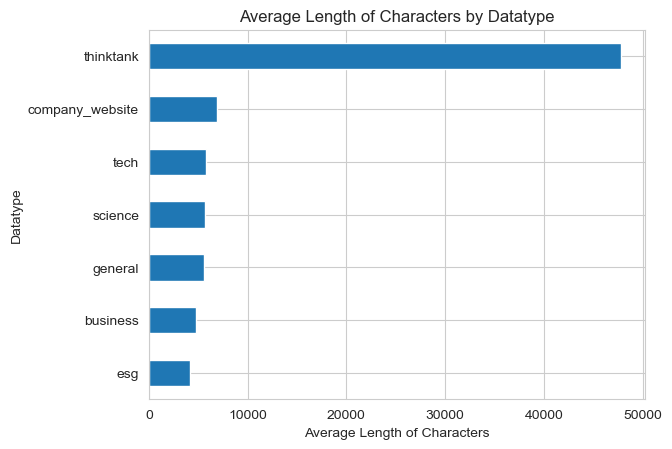

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the average length by datatype
avg_length_by_datatype = df.groupby('datatype')['content'].apply(lambda x: np.mean(x.str.len()))

# Sort the average length in descending order
avg_length_by_datatype_sorted = avg_length_by_datatype.sort_values(ascending=True)

# Create a horizontal bar plot of the average length by datatype
avg_length_by_datatype_sorted.plot(kind='barh')
plt.title("Average Length of Characters by Datatype")
plt.xlabel("Average Length of Characters")
plt.ylabel("Datatype")
plt.show()


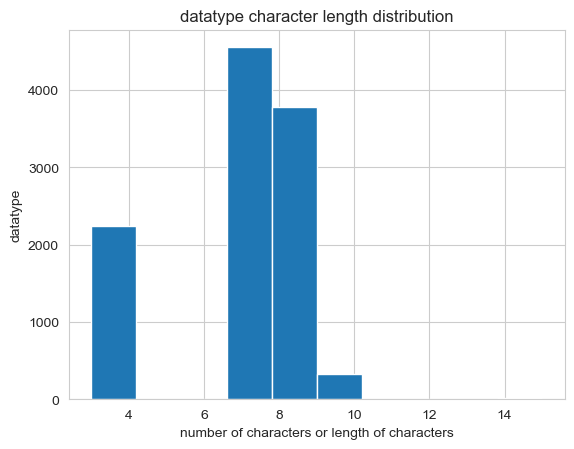

In [14]:
# domain histogram character distribution
df['datatype'].str.len().hist()
plt.title("datatype character length distribution")
plt.xlabel("number of characters or length of characters")
plt.ylabel("datatype")
plt.show()

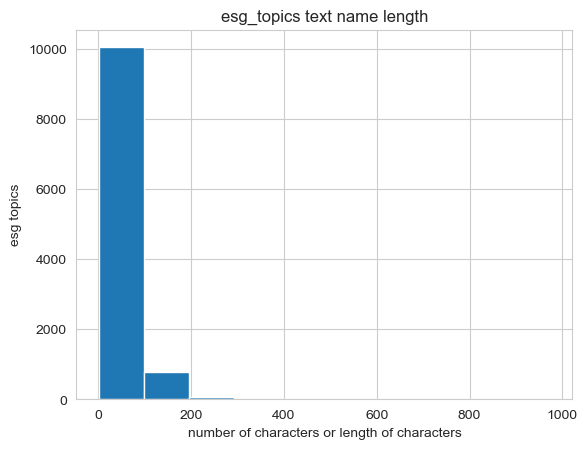

In [15]:
df['esg_topics'].str.len().hist()
plt.title("esg_topics text name length")
plt.xlabel("number of characters or length of characters")
plt.ylabel("esg topics")
plt.show()

The esg topics are mostly 200 words and less.

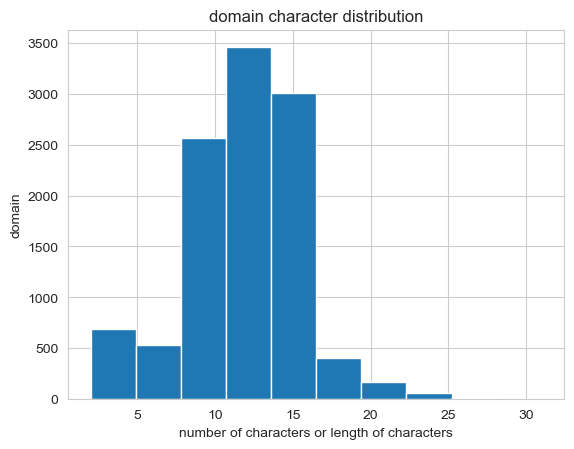

In [16]:
# domain histogram character distribution
df['domain'].str.len().hist()
plt.title("domain character distribution")
plt.xlabel("number of characters or length of characters")
plt.ylabel("domain")
plt.show()

The character count of the domain columns shoes that most charracters are 10 to 15 characters long.

0    10914
Name: internal_encoded, dtype: int64


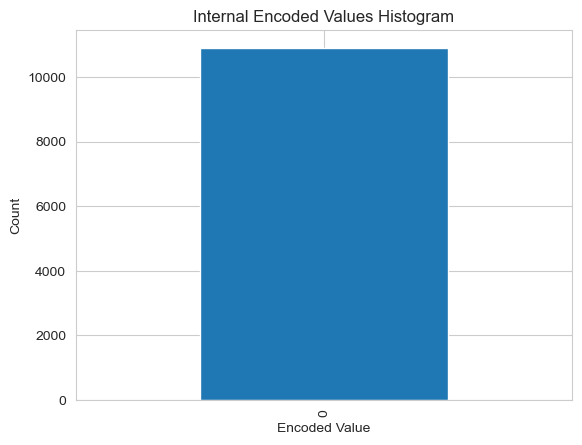

In [17]:
from sklearn.preprocessing import LabelEncoder

# create a label encoder object
le = LabelEncoder()

# fit and transform the 'internal' column of df
df['internal_encoded'] = le.fit_transform(df['internal'])

# print the encoded 'internal' column
print(df['internal_encoded'].value_counts())
# plot the histogram of unique encoded values
df['internal_encoded'].value_counts().plot(kind='bar')
plt.title("Internal Encoded Values Histogram")
plt.xlabel("Encoded Value")
plt.ylabel("Count")
plt.show()

It seems that using the df.dropna() function resulted in the dropping of all internal reports as it had missing values on all the rows that it is located in.

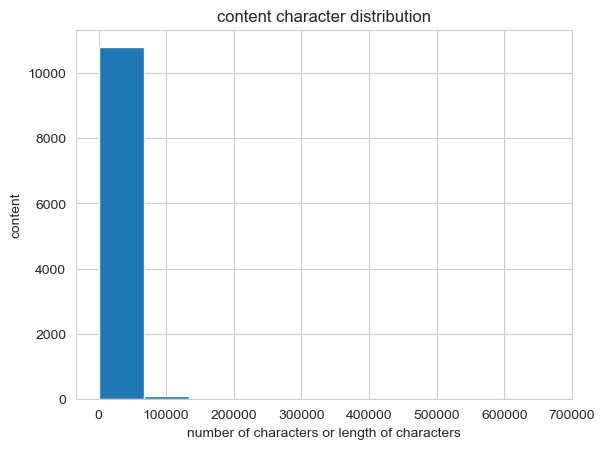

In [18]:
df['content'].str.len().hist()
plt.title("content character distribution")
plt.xlabel("number of characters or length of characters")
plt.ylabel("content")
plt.show()

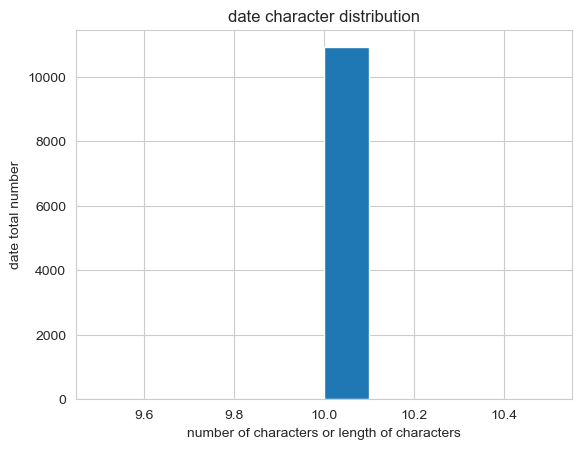

In [19]:
# date  character distribution
df['date'].str.len().hist()
plt.title("date character distribution")
plt.xlabel("number of characters or length of characters")
plt.ylabel("date total number")
plt.show()

### TF-IDF to find the most characteristic words by company

In [20]:
# Use TF-IDF to find the most characteristic words by company
# Drop rows with NaN values in the 'content' column
df = df.dropna(subset=['content'])
# Find the top companies by document count
num_top_companies = 10
top_companies = df['company'].value_counts().nlargest(num_top_companies).index
# Create a list of the reports
reports = list(df['content'])

# Create the vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the data
tfidf = vectorizer.fit_transform(reports)

# Get the most characteristic words for each company
for i, company in enumerate(df['company'].unique()):
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf.toarray()[df['company'] == company][0]
    top_keywords = [feature_names[index] for index in tfidf_scores.argsort()[::-1][:10]]
    print(f"Top keywords for {company}: {', '.join(top_keywords)}")

Top keywords for Adidas AG: desktop, adaptive3d, metal, 3d, zdnet, additive, printing, parts, elegoo, fulop
Top keywords for Airbus SE: airbus, aeroflot, toulouse, pjsc, a350, aircraft, delivered, handovers, detours, blagnac
Top keywords for Allianz SE: alpha, allianz, structured, tournant, funds, investors, fund, frenkel, options, insurer
Top keywords for AkzoNobelNV: lokalise, localization, crv, multilingual, localize, funding, language, translation, native, 3vc
Top keywords for BMW: 300m, ups, targeting, venture, hybrid, bmw, transportation, mid, giant, fund
Top keywords for Bayer AG: bayer, cinven, esp, bloomberg, pest, people, beaker, lawns, infestations, cvc
Top keywords for Beiersdorf AG: skin, foundation, makeup, itâ, radiant, complexion, hydrating, comedogenic, like, ageing
Top keywords for Brenntag: ransomware, constella, ransom, malicious, attacks, phishing, user, attackers, network, emails
Top keywords for Continental AG: rubber, natural, footwear, market, increasing, thail

In [21]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
# Drop rows with NaN values in the 'content' column
df = df.dropna(subset=['content'])
# Find the top companies by document count
num_top_companies = 10
top_companies = df['company'].value_counts().nlargest(num_top_companies).index

# Create a list of the reports
reports = list(df['content'])

# Create the vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the data
tfidf = vectorizer.fit_transform(reports)

# Get the most characteristic words for each of the top companies
feature_names = vectorizer.get_feature_names_out()

for company in top_companies:
    company_indices = df['company'] == company
    company_tfidf_scores = tfidf[company_indices].toarray().mean(axis=0)
    top_keyword_indices = company_tfidf_scores.argsort()[::-1][:10]
    top_keywords = [feature_names[index] for index in top_keyword_indices]
    
    print(f"Top keywords -> {company}: {', '.join(top_keywords)}")
    


Top keywords -> RWE AG: rwe, wind, energy, gas, offshore, coal, lng, said, hydrogen, power
Top keywords -> Siemens Healthineers AG: imaging, 2022, siemens, august, healthineers, medical, healthcare, radiology, patient, ct
Top keywords -> Volkswagen AG: volkswagen, vw, electric, said, id, car, vehicles, battery, vehicle, cars
Top keywords -> Merck KGaA: merck, drug, patients, cancer, keytruda, treatment, fda, clinical, trial, covid
Top keywords -> Daimler AG: mercedes, benz, electric, said, car, vehicles, amg, vehicle, daimler, hamilton
Top keywords -> BMW: bmw, electric, car, vehicles, vehicle, said, new, battery, co2, und
Top keywords -> Siemens Energy: siemens, energy, wind, gamesa, offshore, turbine, gas, renewable, hydrogen, turbines
Top keywords -> AkzoNobelNV: basf, market, diversityinc, said, gas, diversity, 2021, ranked, production, companies
Top keywords -> Porsche: porsche, electric, car, said, cars, volkswagen, vehicles, taycan, battery, vw
Top keywords -> Deutsche Telekom A

### Word frequency by Company

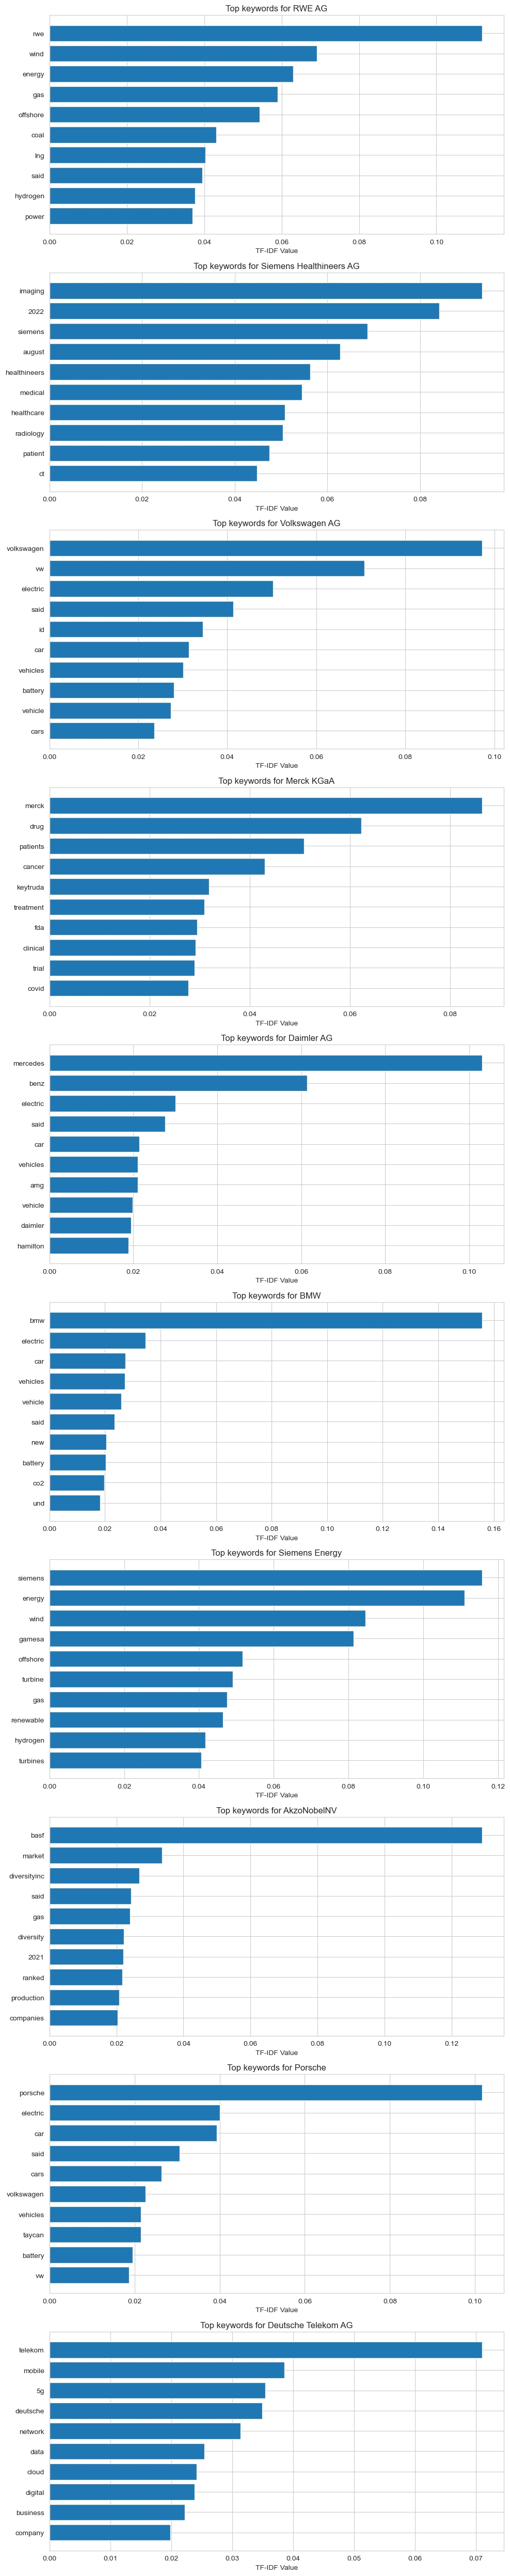

In [22]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Drop rows with NaN values in the 'content' column
df = df.dropna(subset=['content'])
# Find the top companies by document count
num_top_companies = 10
top_companies = df['company'].value_counts().nlargest(num_top_companies).index

# Create a list of the reports
reports = list(df['content'])

# Create the vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the data
tfidf = vectorizer.fit_transform(reports)

# Get the most characteristic words for each of the top companies
feature_names = vectorizer.get_feature_names_out()

# Plot the top keywords for each of the top companies
fig, axs = plt.subplots(num_top_companies, figsize=(10, 5 * num_top_companies))

for ax, company in zip(axs, top_companies):
    company_indices = df['company'] == company
    company_tfidf_scores = tfidf[company_indices].toarray().mean(axis=0)
    top_keyword_indices = company_tfidf_scores.argsort()[::-1][:10]
    top_keywords = [feature_names[index] for index in top_keyword_indices]
    top_scores = [company_tfidf_scores[index] for index in top_keyword_indices]
    
    ax.barh(top_keywords, top_scores)
    ax.set_title(f"Top keywords for {company}")
    ax.set_xlabel("TF-IDF Value")
    ax.invert_yaxis()

plt.tight_layout()
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


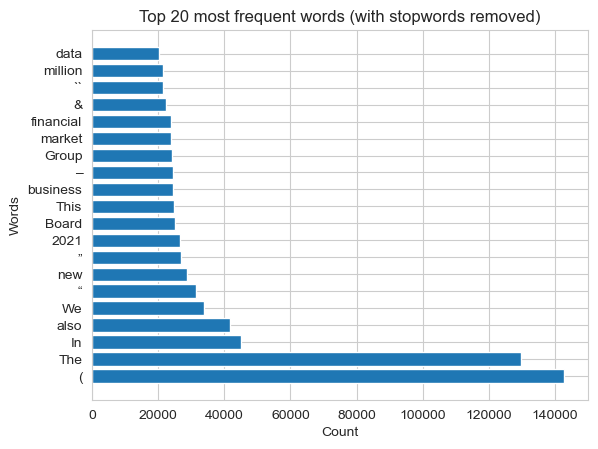

In [23]:
import nltk
from nltk.corpus import stopwords
# Set the whitegrid style
import seaborn as sns
sns.set_style("whitegrid")
# Stopwords are common words in a language that are often considered less informative or less meaningful 
# for text analysis tasks. These words usually include articles, prepositions, conjunctions, and pronouns,
# such as "a," "an," "the," "and," "in," "on," "with," "he," "she," "it," etc. 
# Because stopwords are frequently used in any text, they tend to carry less distinctive information
# about the content of a document.

df = pd.read_csv('esg_documents_for_dax_companies.csv', delimiter = '|', index_col = 0)
nltk.download('stopwords')
stop = set(stopwords.words('english'))

corpus = []
df = df[df['content'].notnull() & df['esg_topics'].notnull()]
df_content = df['content'].str.split()
df_esg_topics = df['esg_topics'].str.split()

corpus = [word for doc in df_content for word in doc if word not in stop] + \
         [word for doc in df_esg_topics for word in doc if word not in stop]
         
from collections import Counter
from matplotlib import pyplot as plt

word_count = Counter(corpus)

# Get the top 20 words
top_words = word_count.most_common(20)

# Separate the words and their counts into separate lists
words, counts = zip(*top_words)

# Plot the bar chart
plt.barh(words, counts)
plt.xlabel('Count')
plt.ylabel('Words')
plt.title('Top 20 most frequent words (with stopwords removed)')
plt.show()


The annual report column has the highest average length for each unique value in the datatype column.

In [24]:
# Word segmentation and word frequencies
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd
# load dataset
df = pd.read_csv('esg_documents_for_dax_companies.csv', delimiter = '|', index_col = 0)
# Drop rows with NaN values in the 'content' column
df = df.dropna(subset=['content'])
# Fill missing values in the 'content' column with empty strings
#df['content'] = df['content'].fillna('')
# drop missing values in the 'content' column 
#df['content'] = df['content'].dropna(subset=['content'])
vectorizer = CountVectorizer(stop_words='english')
word_matrix = vectorizer.fit_transform(df['content'])
word_freq = word_matrix.sum(axis=0).A1
word_freq_df = pd.DataFrame({'word': vectorizer.get_feature_names(), 'frequency': word_freq})
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)
print(word_freq_df.head(20))  # show top 20 words by frequency from the content column
print("top 20 words by frequency from the content column")

               word  frequency
12393          2021      49990
110634        group      44315
143132       market      43604
71365       company      43244
230246         year      42928
142231   management      42912
100107    financial      41346
11986          2020      41035
183501       report      40898
60424      business      36112
155818          new      34797
56988         board      32127
147910      million      31436
78704          data      29854
108345       global      28525
189773         said      26474
52098         based      25291
122698  information      23589
92396        energy      22257
220039          use      20844
top 20 words by frequency from the content column


C:\Users\chris\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


C:\Users\chris\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


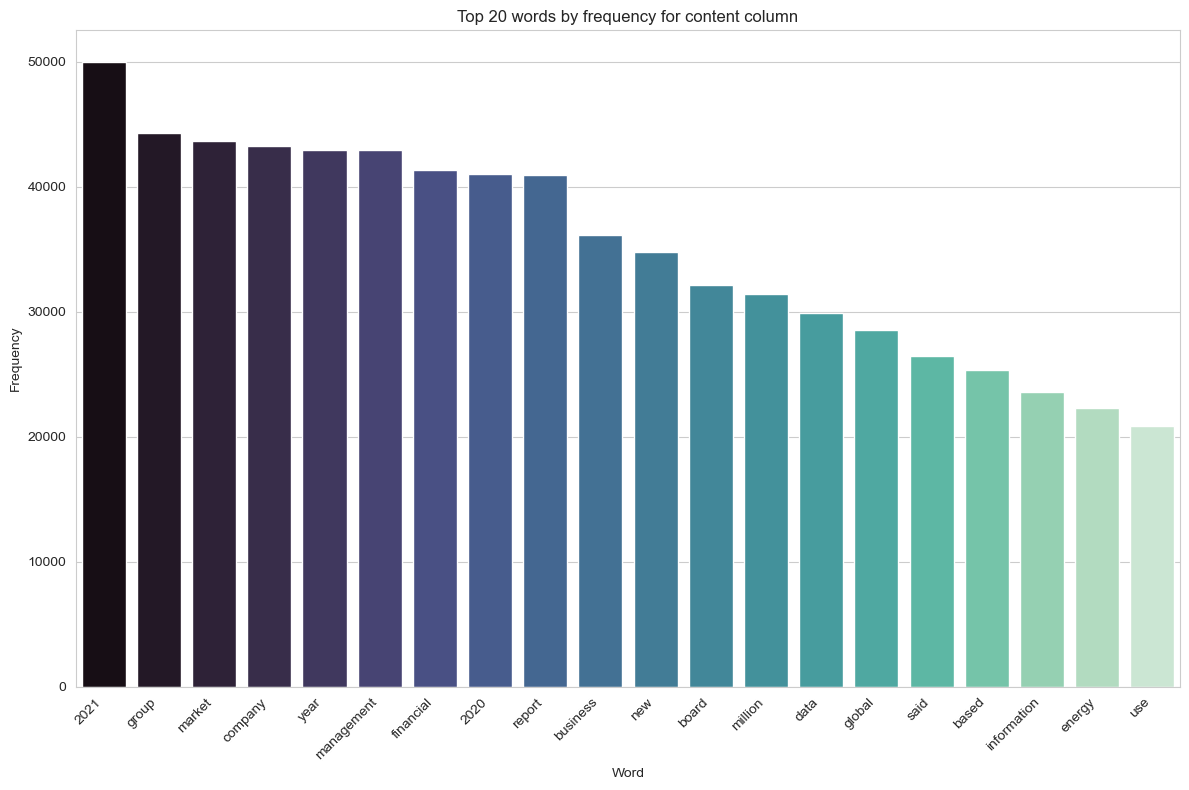

In [25]:
#plot the word freq df as a graphical plot
import seaborn as sns
#import matplotlib.pyplot as plt
#from sklearn.feature_extraction.text import CountVectorizer
sns.set_style('whitegrid')
#import pandas as pd
# load dataset
#df = pd.read_csv('esg_documents_for_dax_companies.csv', delimiter = '|', index_col = 0)
# Fill missing values in the 'content' column with empty strings
#df['content'] = df['content'].fillna('')
vectorizer = CountVectorizer(stop_words='english')
word_matrix = vectorizer.fit_transform(df['content'])
word_freq = word_matrix.sum(axis=0).A1
word_freq_df = pd.DataFrame({'word': vectorizer.get_feature_names(), 'frequency': word_freq})
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)
top_words_df = word_freq_df.head(20)
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='word', y='frequency', data=top_words_df, palette='mako')
ax.set_title('Top 20 words by frequency for content column')
ax.set_xlabel('Word')
ax.set_ylabel('Frequency')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

# The number of Documents per company

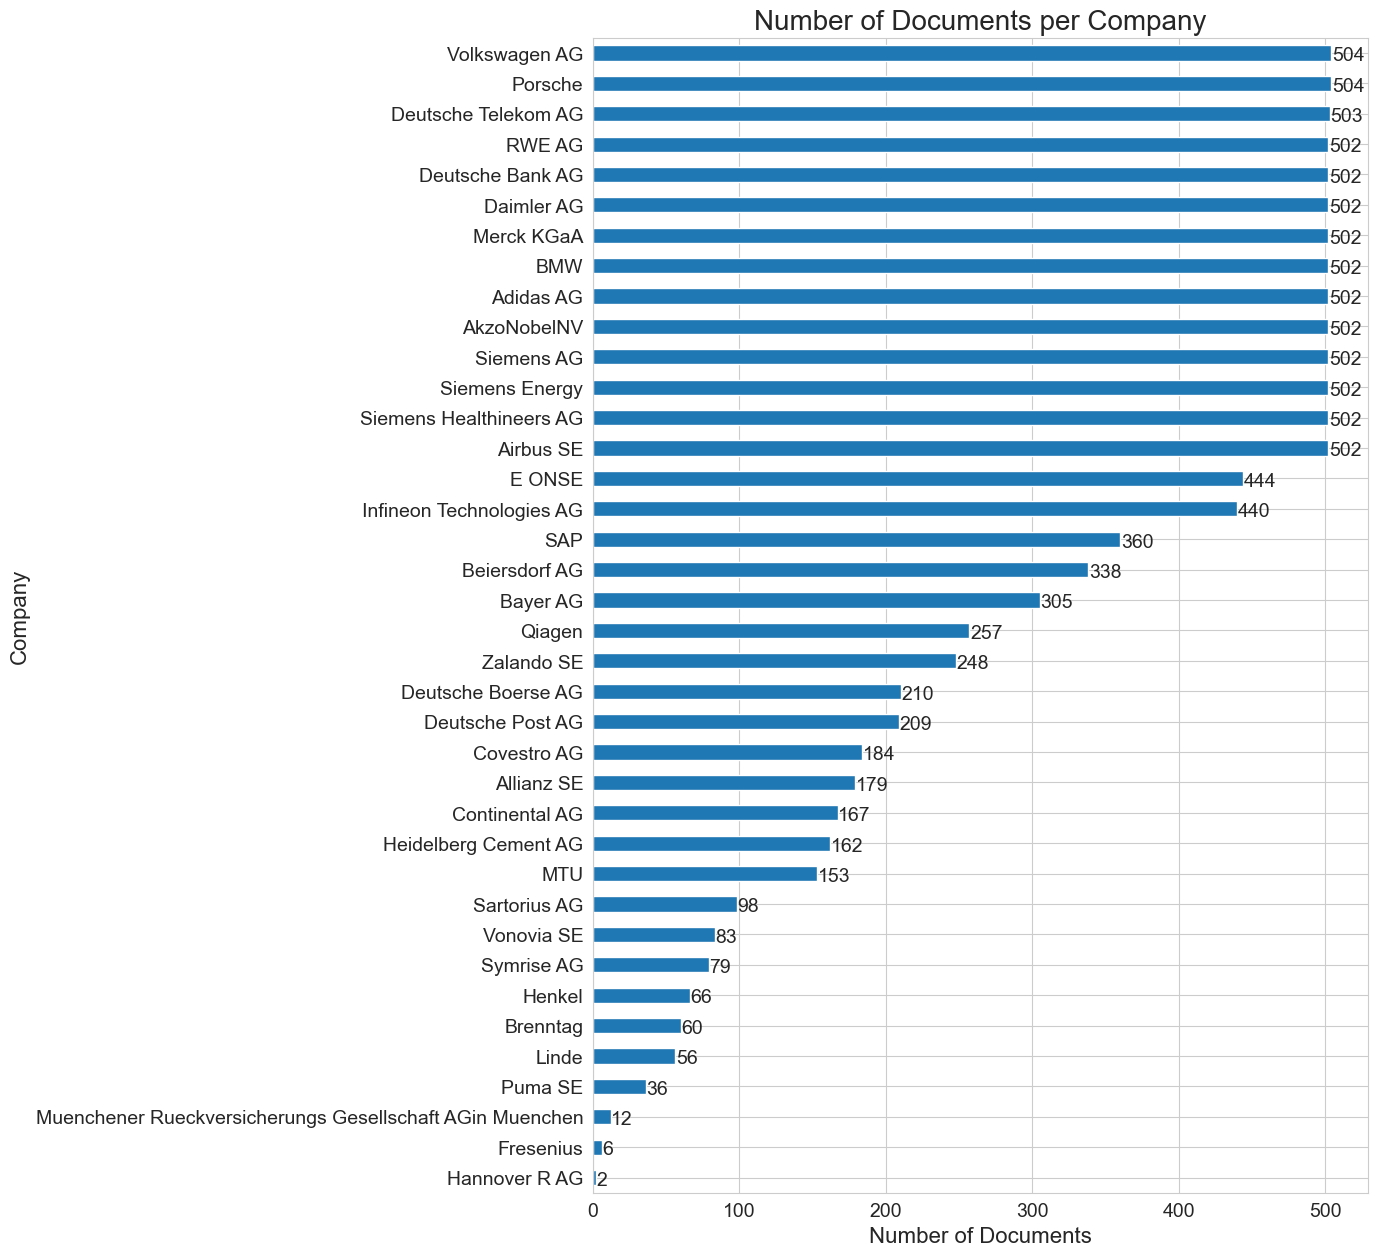

In [26]:
# Set the whitegrid style
import seaborn as sns
sns.set_style("whitegrid")
#df.groupby("company")["content"].count().sort_values(ascending=False).plot(kind="barh")
ax = df.groupby("company")["content"].count().sort_values(ascending=True).plot(kind="barh", figsize=(10, 15))

# Set title, labels, and adjust the plot size
ax.set_title("Number of Documents per Company", fontsize=20)
ax.set_xlabel("Number of Documents", fontsize=16)
ax.set_ylabel("Company", fontsize=16)
ax.tick_params(axis='both', labelsize=14)

# Add the number of documents beside each bar
for index, value in enumerate(df.groupby("company")["content"].count().sort_values(ascending=True)):
    ax.text(value + 0.5, index - 0.25, str(value), fontsize=14)
    
# Display the plot
#plt.tight_layout()
plt.show()


This output shows the number of ESG documents for each company in the dataset. The company names are listed on the left, followed by the corresponding number of ESG documents on the right. The companies are sorted in descending order by the number of documents.

For example, Porsche and Volkswagen AG both have 504 ESG documents, making them the companies with the highest number of ESG documents in the dataset. On the other hand, Hannover R AG has only 2 ESG documents, making it the company with the lowest number of ESG documents.

This information can help you understand the distribution of ESG documents across different companies in the dataset, as well as identify which companies have more or less ESG-related information available.

posx and posy should be finite values
posx and posy should be finite values


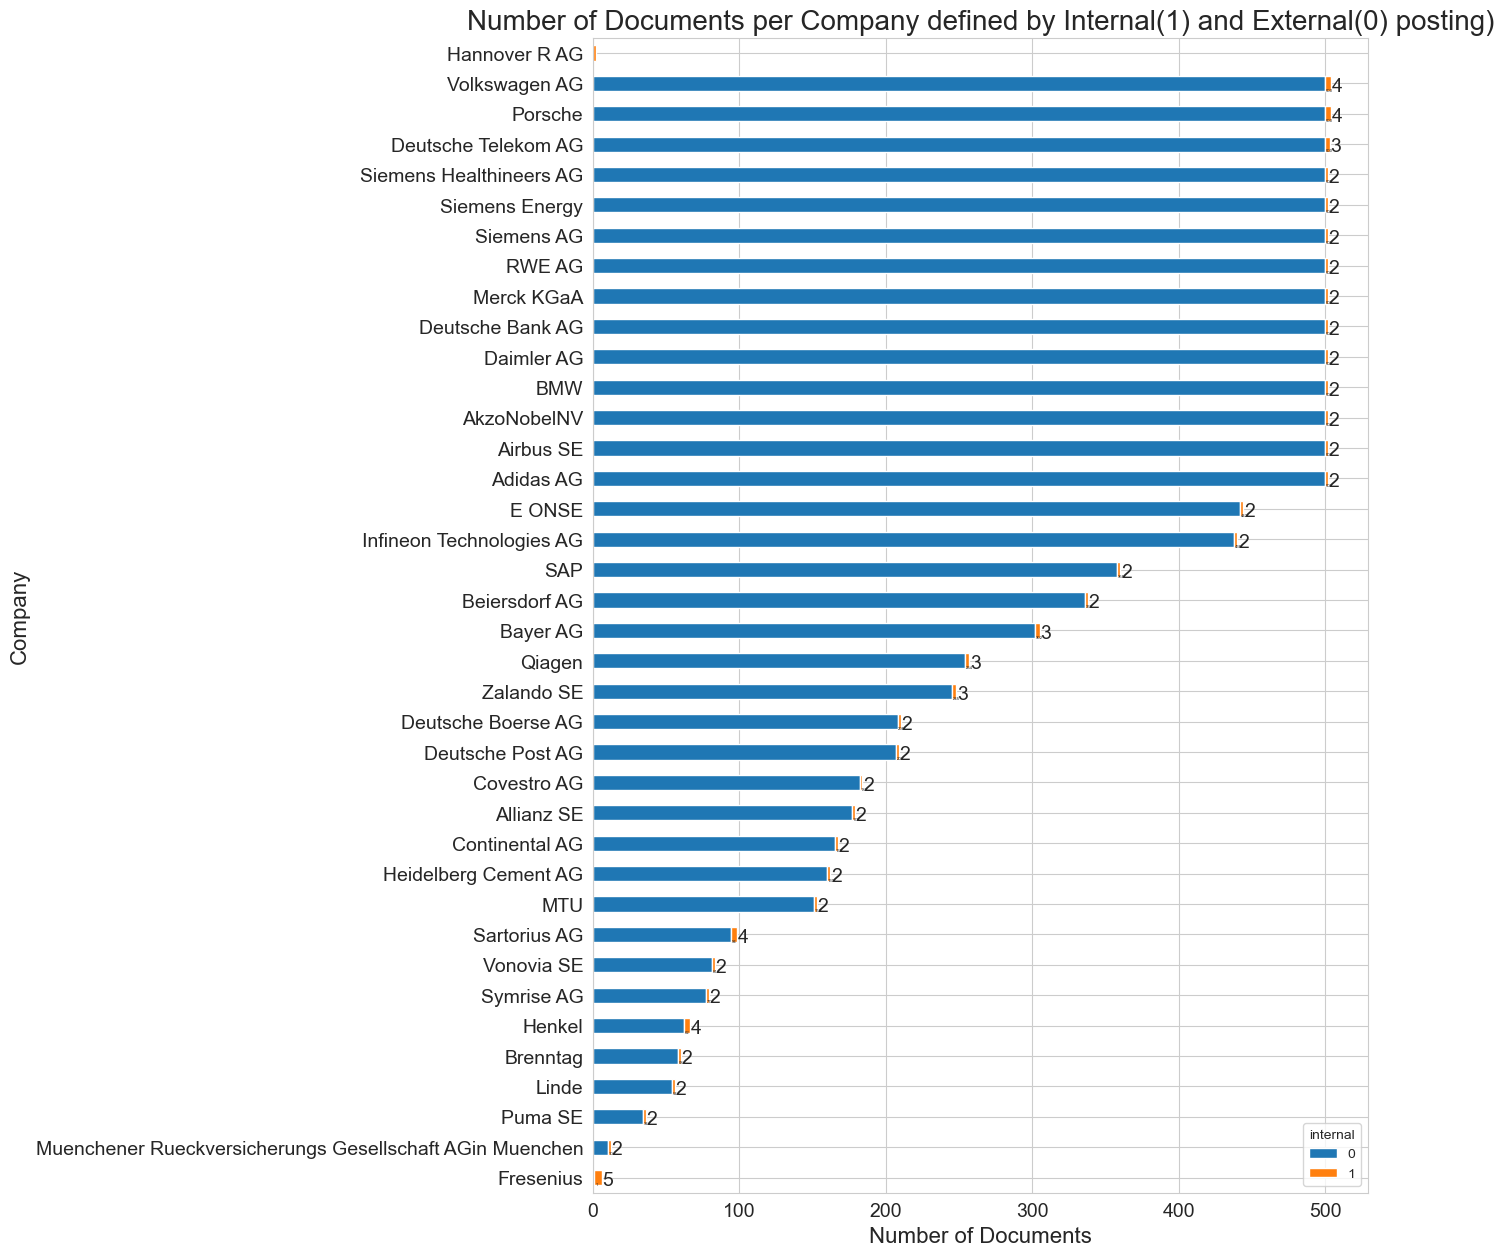

In [27]:
# Set the whitegrid style
import seaborn as sns
sns.set_style("whitegrid")
ax = df.groupby(["company", "internal"])["content"].count().unstack().sort_values(by=[0, 1], ascending=True).plot(kind='barh', stacked=True, figsize=(10, 15))

# Set title, labels, and adjust the plot size
ax.set_title("Number of Documents per Company defined by Internal(1) and External(0) posting)", fontsize=20)
ax.set_xlabel("Number of Documents", fontsize=16)
ax.set_ylabel("Company", fontsize=16)
ax.tick_params(axis='both', labelsize=14)

# Add the number of documents beside each bar
grouped_data = df.groupby(["company", "internal"])["content"].count().unstack().sort_values(by=[0, 1], ascending=True)
for index, (external, internal) in enumerate(zip(grouped_data[0], grouped_data[1])):
    if not pd.isna(external):
        ax.text(external + 0.5, index - 0.25, str(int(external)), fontsize=3)
    if not pd.isna(internal):
        ax.text(external + internal + 0.5, index - 0.25, str(int(internal)), fontsize=14)

# Display the plot
#plt.tight_layout()
plt.show()


['Social']                     454
['EMobility']                  436
['Environment']                210
['RenewableEnergy']            186
['GenderDiversity']            181
['Privacy']                    149
['Privacy', 'Transparency']    147
['HumanCapital']               118
['ValueChain']                 106
Name: esg_topics, dtype: int64


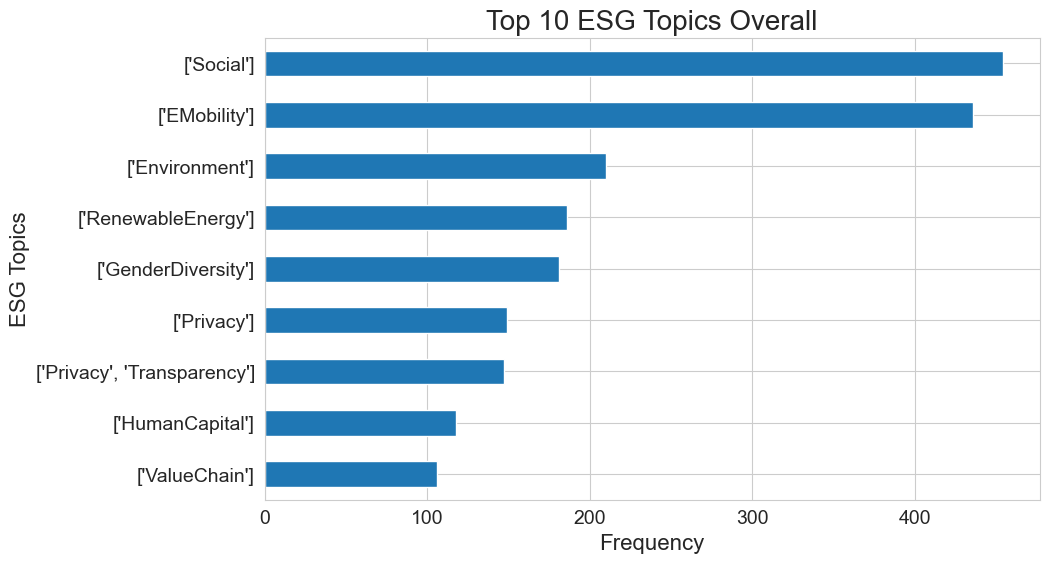

In [28]:
# Set the whitegrid style
import seaborn as sns
sns.set_style("whitegrid")
# Get the top 10 ESG topics overall
top_topics = df['esg_topics'].value_counts().head(10)
top_topics = top_topics[top_topics.index != '[]']
print(top_topics)

import matplotlib.pyplot as plt

# Get the top 10 ESG topics overall
top_topics = df['esg_topics'].value_counts().head(10)
top_topics = top_topics[top_topics.index != '[]']

# Create a horizontal bar plot
ax = top_topics.plot(kind='barh', figsize=(10, 6))

# Set title, labels, and adjust the plot size
ax.set_title("Top 10 ESG Topics Overall", fontsize=20)
ax.set_xlabel("Frequency", fontsize=16)
ax.set_ylabel("ESG Topics", fontsize=16)
ax.tick_params(axis='both', labelsize=14)

# Invert the y-axis to show the highest value at the top
ax.invert_yaxis()

# Display the plot
plt.show()


In [29]:
# Cleaning of table of contents, contact details, etc.:
# This step requires some domain knowledge and understanding of the dataset.
# However, here's an example of how you can remove email addresses and URLs from the content.
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)  # remove email addresses
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)  # remove URLs
    return text


### Time Series of ESG topic Distributions

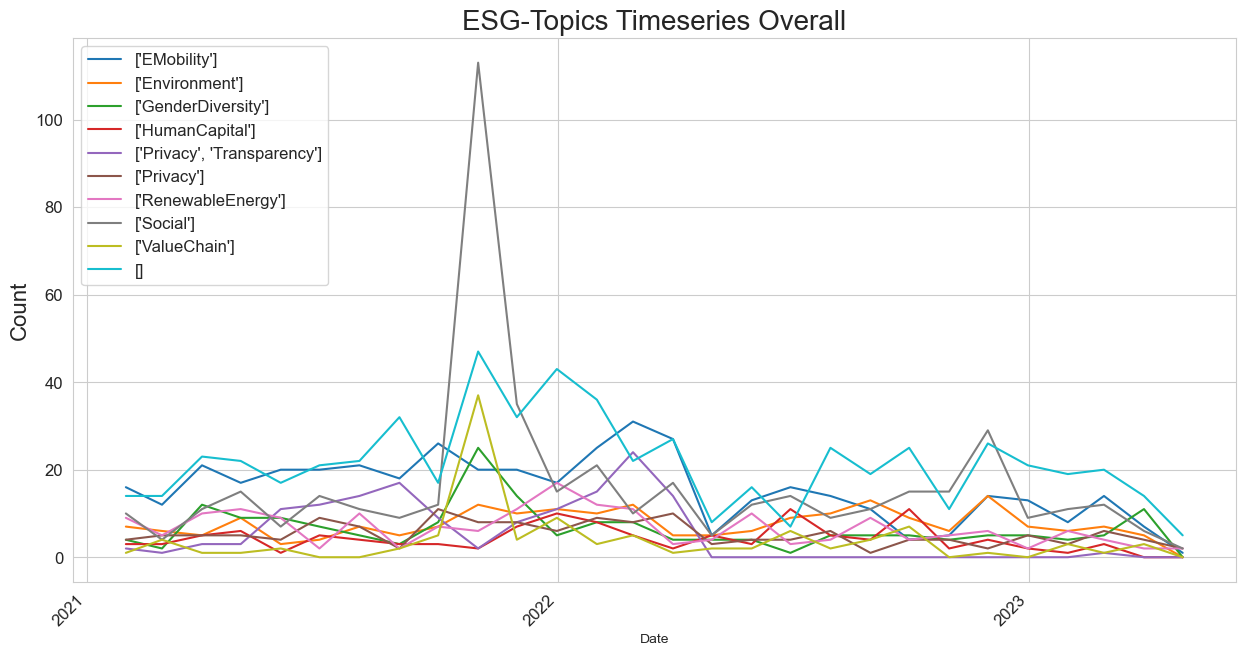

In [43]:
# Function to create time series dataframe
def create_timeseries_dataframe(df):

    # Copy DataFrame and remove all strange datatypes which cause a ParserError
    df_timeseries= df.drop(df[df['date'].isin(['p.DE-03-31', 'bayer-03-31'])].index)

    # Convert date to datetime
    # Ensure the 'date' column is in datetime format
    df_timeseries['date'] = pd.to_datetime(df_timeseries['date'], errors='coerce')

    # explode 'esg_topics' column and keep other columns
    df_timeseries = df_timeseries.explode('esg_topics').reset_index(drop=True)

    # Remove empty strings
    df_timeseries = df_timeseries[df_timeseries['esg_topics'] != '']

    # Set the date column it as the index of the DataFrame
    return df_timeseries.set_index('date')
# Function to create overall esg-topics time series
def create_timeseries_overall(df):

    # Group the data by month and esg_topics and count the occurrences
    df_grouped_esg_topic = df.groupby([pd.Grouper(freq='M'), 'esg_topics']).size().reset_index(name='count')

    # Get the top 10 esg_topics by count
    top_10_esg_topics = df_grouped_esg_topic.groupby('esg_topics').sum().nlargest(10, 'count').index

    # Filter the original data to keep only the top 10 esg_topics
    df_top_10_esg_topics = df_grouped_esg_topic[df_grouped_esg_topic['esg_topics'].isin(top_10_esg_topics)]

    # Pivot the data to have esg_topics as columns
    df_pivot = df_top_10_esg_topics.pivot_table(index='date', columns='esg_topics', values='count', fill_value=0)

    # Create the line plot
    fig, ax = plt.subplots(figsize=(15, 8))
    df_pivot.plot(ax=ax, x_compat=True)
    
    # Format the x-axis
    years = mdates.YearLocator()
    months = mdates.MonthLocator()
    years_fmt = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)

    # Rotate the x-axis labels
    plt.xticks(rotation=45, ha='right')

    # Add the legend
    ax.legend(df_pivot.columns, loc='upper left', fontsize=12)

    # Set title, labels, and adjust the plot size
    ax.set_title("ESG-Topics Timeseries Overall", fontsize=20)
    ax.set_xlabel("Date", fontsize=10)
    ax.set_ylabel("Count", fontsize=16)
    ax.tick_params(axis='both', labelsize=12)

    # Show the plot
    plt.show()
# Display overall time series
create_timeseries_overall(df_timeseries)

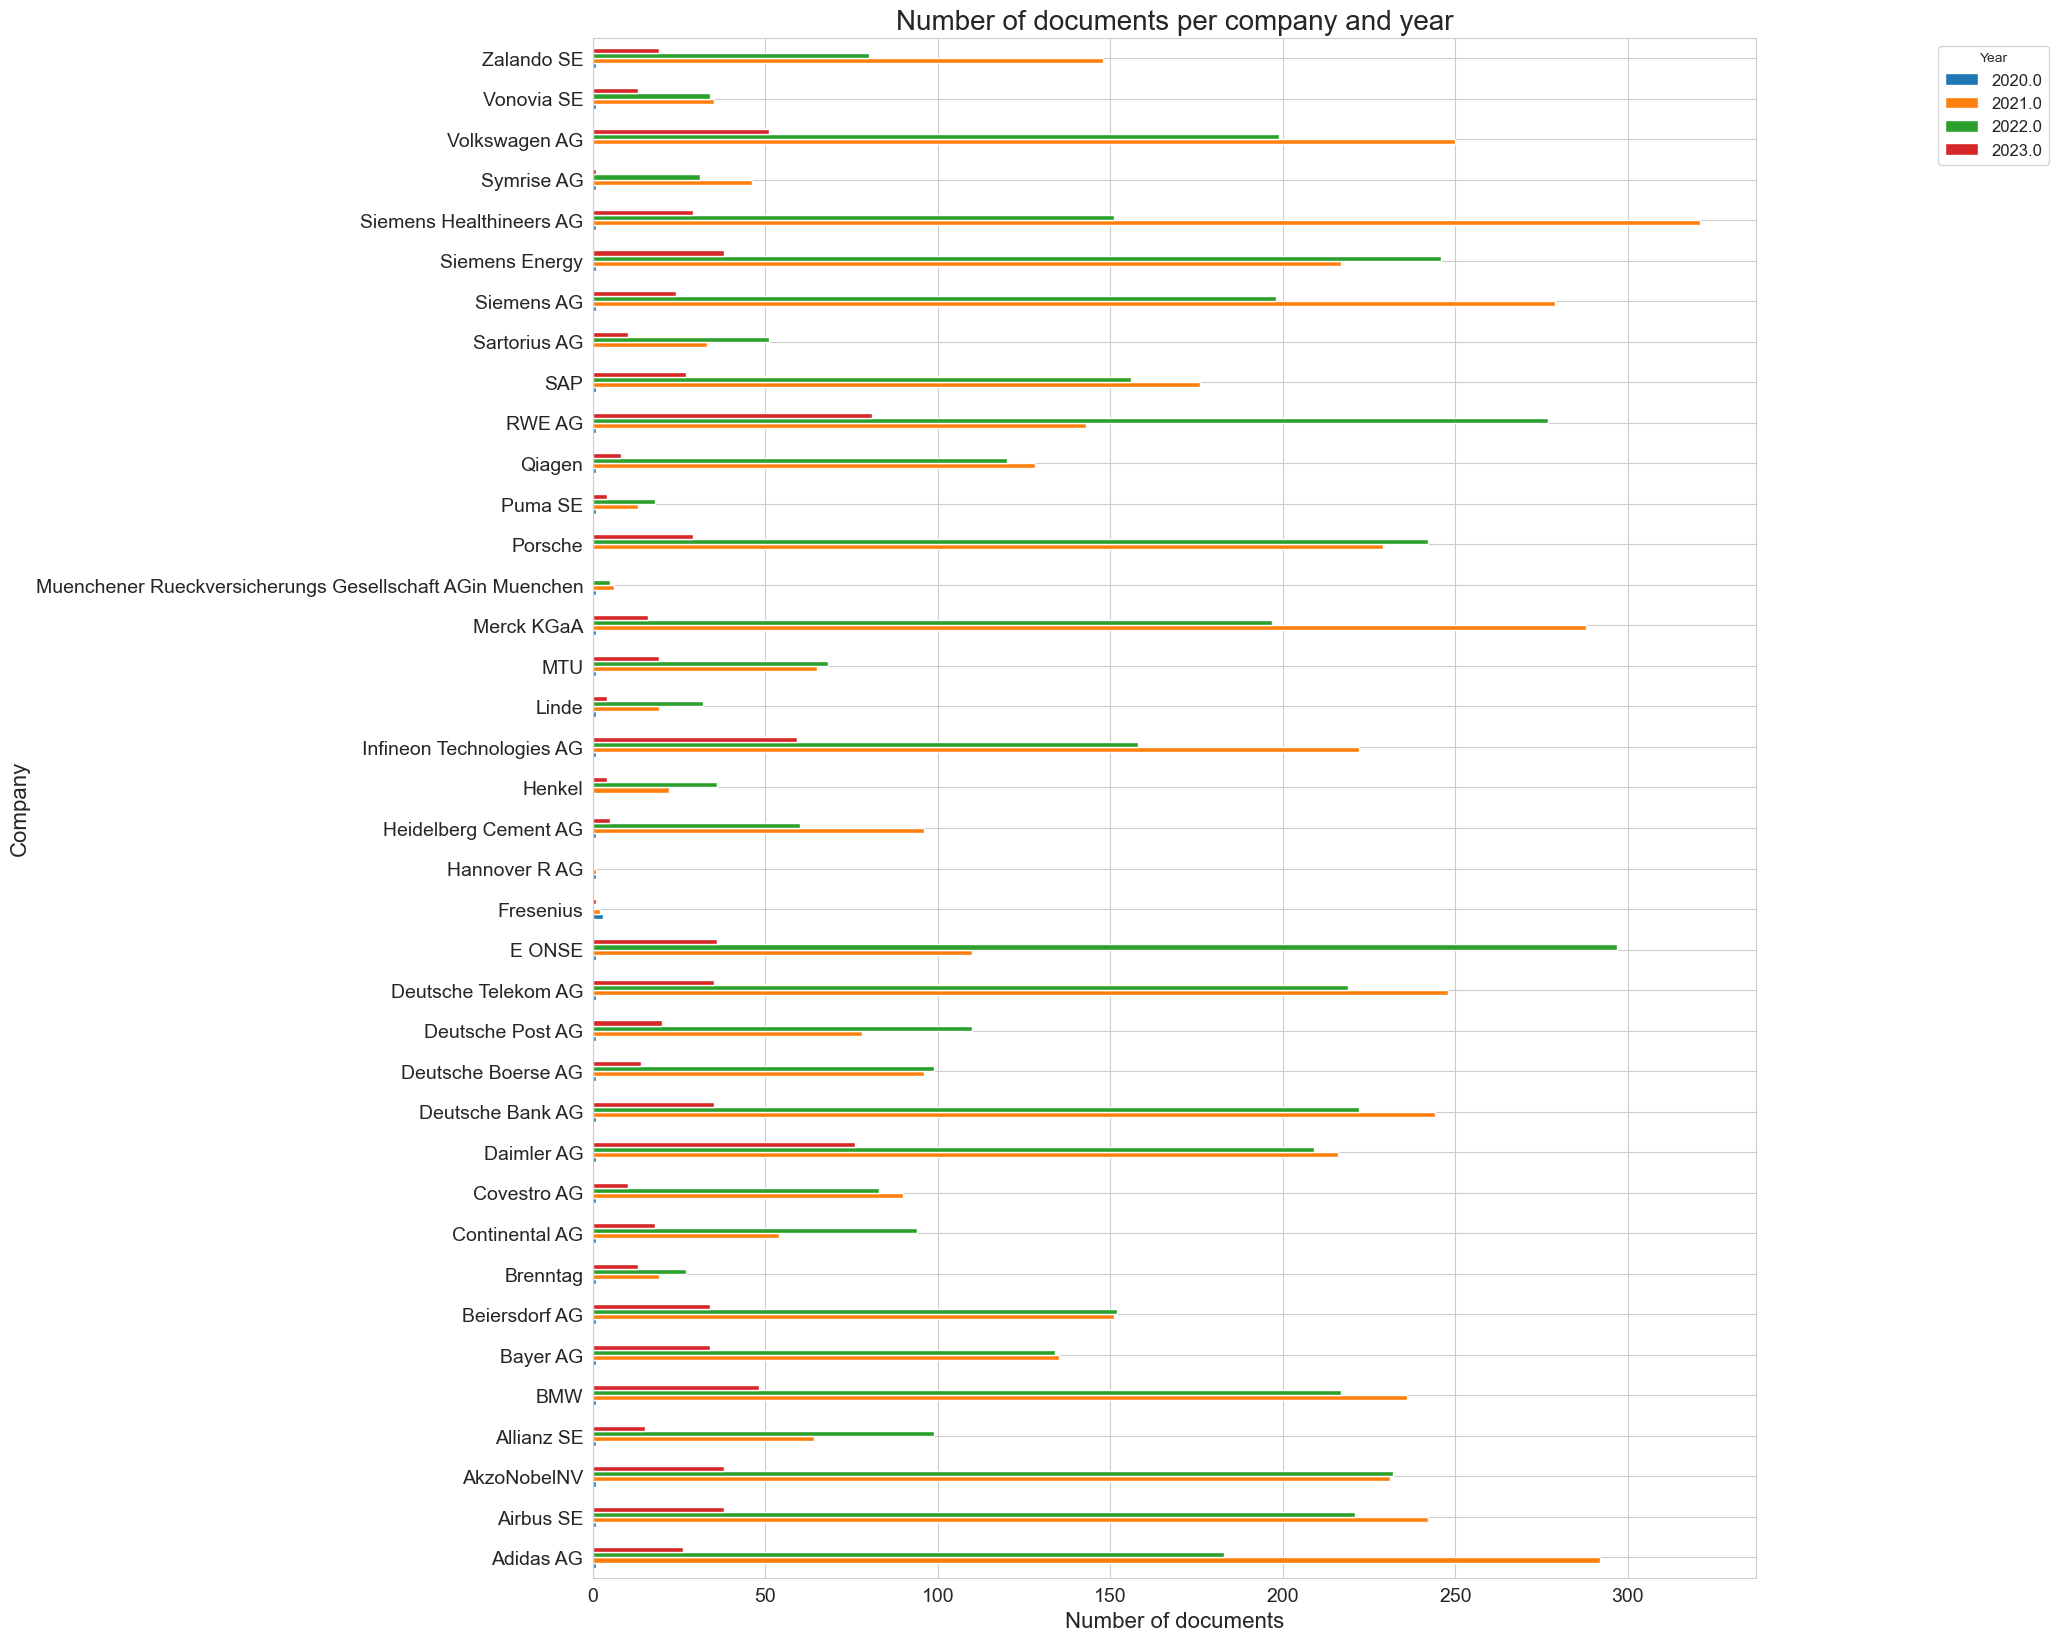

In [31]:
import matplotlib.pyplot as plt

# Set the whitegrid style
import seaborn as sns
sns.set_style("whitegrid")

# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Group data by company and year
grouped_data = df.groupby(['company', df['date'].dt.year])['date'].count().unstack()

# Create a horizontal bar plot
fig, ax = plt.subplots(figsize=(15, 20))
grouped_data.plot(kind='barh', ax=ax)

# Set title, labels, and adjust the plot size
ax.set_title("Number of documents per company and year", fontsize=20)
ax.set_xlabel("Number of documents", fontsize=16)
ax.set_ylabel("Company", fontsize=16)
ax.tick_params(axis='both', labelsize=14)

# Add the legend below the plot with increased distance
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper left', fontsize=12, title='Year')

# Show the plot
#plt.tight_layout()
plt.show()


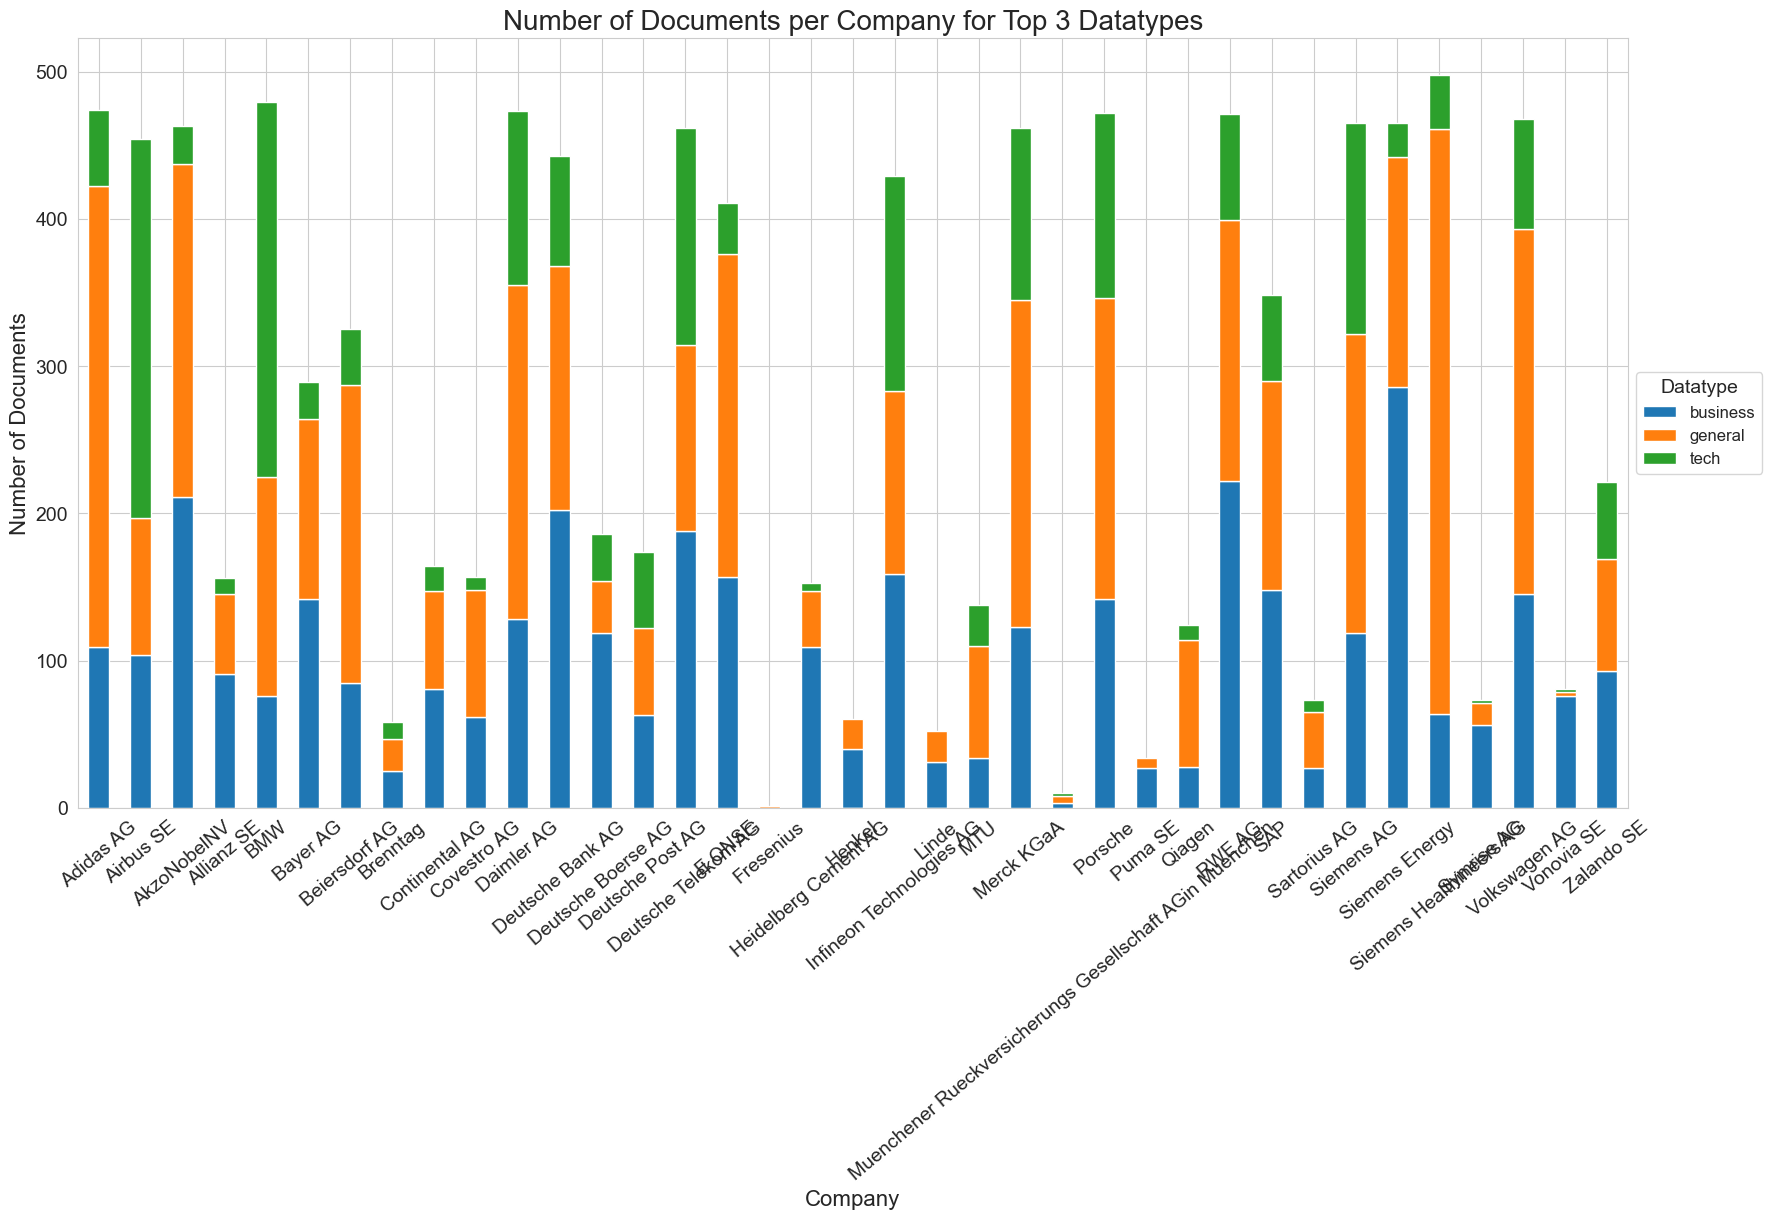

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
# Filter data for the top 3 datatypes
reports_top_3 = df[df["datatype"].isin(["general", "business", "tech"])]

# Group data by datatype and company
grouped_data = reports_top_3.groupby(["datatype", "company"])["content"].count().unstack().T

# Create a bar plot
ax = grouped_data.plot(kind='bar', stacked=True, figsize=(20, 10))

# Set title, labels, and adjust the plot size
ax.set_title('Number of Documents per Company for Top 3 Datatypes', fontsize=20)
ax.set_xlabel('Company', fontsize=16)
ax.set_ylabel('Number of Documents', fontsize=16)
ax.tick_params(axis='both', labelsize=14)

# Rotate x-axis tick labels
plt.xticks(rotation=40)

# Format the legend
ax.legend(title='Datatype', title_fontsize=14, fontsize=12, loc='center left', bbox_to_anchor=(1.0, 0.5))

#plt.tight_layout()
plt.show()


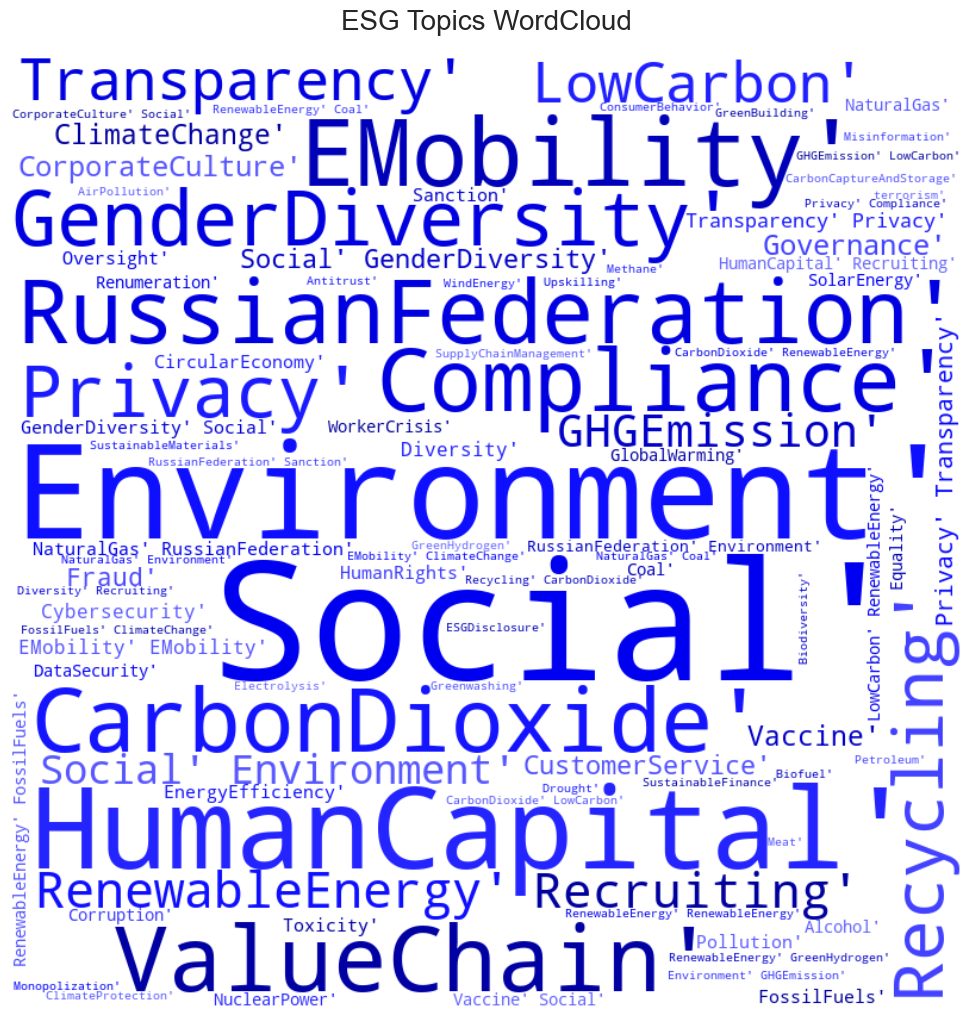

In [33]:
from wordcloud import WordCloud, STOPWORDS
from random import randint
# Define a custom color function
def custom_color_func(*args, **kwargs):
    return "hsl(240, 100%%, %d%%)" % randint(30, 70)

# Configure the WordCloud object
wordcloud = WordCloud(
    width=800,
    height=800,
    background_color='white',
    stopwords=STOPWORDS,
    min_font_size=10,
    color_func=custom_color_func,
).generate(df.esg_topics.str.cat())

# Plot the WordCloud image
plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("ESG Topics WordCloud", fontsize=20, pad=20)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


                datatype  count  in_%_of_total
0                general   4424           40.2
1               business   3775           34.3
2                   tech   2067           18.8
3              thinktank    329            3.0
4                    esg    178            1.6
5                science    128            1.2
6  sustainability_report     51            0.5
7          annual_report     40            0.4
8        company_website     13            0.1


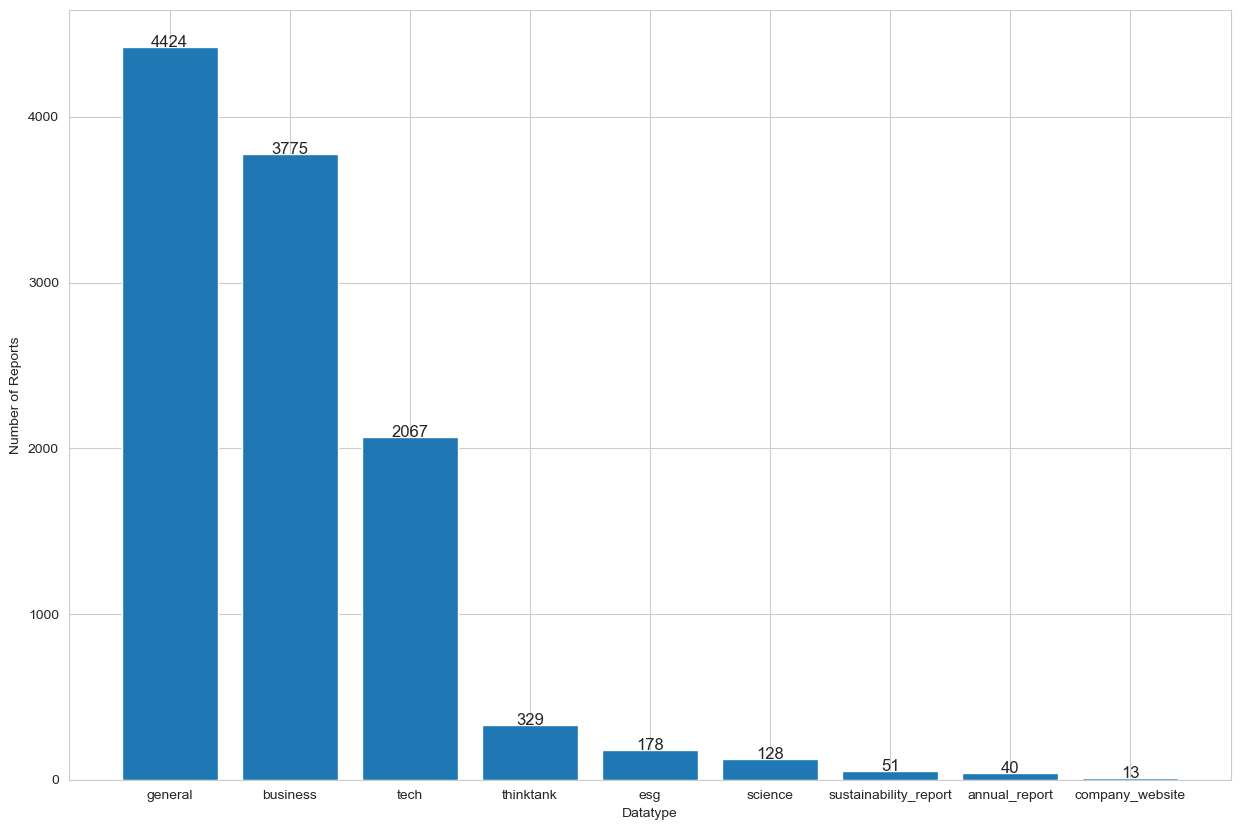

top 3 industries share: 93.3 %


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
# Function to count reports per datatype
def count_reports_by_datatype(df):

    # Create grouped framework to count number of reports per datatype
    df_grouped_datatype = df.groupby('datatype').agg(count=('content', 'count')).sort_values(by='count', ascending=False).reset_index()
    df_grouped_datatype['in_%_of_total'] = round(df_grouped_datatype['count'] / df_grouped_datatype['count'].sum() * 100, 1)
    print(df_grouped_datatype)

    # Configure bar chart
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.bar(df_grouped_datatype['datatype'], df_grouped_datatype['count'])
    ax.set_ylabel("Number of Reports")
    ax.set_xlabel("Datatype")

    # Add count labels on top of bars
    for i, row in df_grouped_datatype.iterrows():
        ax.text(i, row['count'] + 1, str(row['count']), ha='center', fontsize=12)

    # Show plot
    plt.show()

    # Print share of business, general & tech
    print('top 3 industries share:', round(df_grouped_datatype.loc[df_grouped_datatype['datatype'].isin(['business', 'general', 'tech'])]['count'].sum() / df_grouped_datatype['count'].sum() * 100, 1), '%')

# Create and display table and figure
count_reports_by_datatype(df)


In [35]:
#!pip install wordcloud

##### The possible detailed data cleaning steps are listed below:

### Data Cleaning and preprocessing step:

In [36]:
# cleaning the date columns
invalid_dates = df[df['date'].isna()]
print(invalid_dates)
df.dropna(subset=['date'], inplace=True)
invalid_dates = df['date'][pd.isnull(df['date'])]
num_invalid_dates = len(invalid_dates.unique())
print("Number of unique invalid dates:", num_invalid_dates)


           company                                            content  \
24          Henkel  Sustainability Report 2020 About this report T...   
30          Henkel  Sustainability Report 2018 About this report T...   
32        Bayer AG  Five-Year Summary Bayer Annual Report 2018 Fiv...   
34   Volkswagen AG  SUSTAINABILITY REPORT 2020 CONTENTS FOREWORD A...   
38    Sartorius AG  Sartorius Group 2021 Annual Report Key Figures...   
39         Porsche  Courage. Annual and Sustainability Report of P...   
53         Porsche  Responsibility. 04 LETTER FROM THE EXECUTIVE B...   
55         Porsche  SCAN THIS CHART – how to use the augmented rea...   
56   Volkswagen AG  SUSTAINABILITY REPORT 2018 “ON DECEMBER 12, 20...   
62   Volkswagen AG  SUSTAINABILITY REPORT 2021 NEW AUTO: VOLKSWAGE...   
70    Sartorius AG  Sartorius Group 2019 Annual Report 9 Order Int...   
94          Henkel  Sustainability Report About this report Tradit...   
137   Sartorius AG  Sartorius Group 2018 Annual Rep

In [37]:
#Data Cleaning and preprocessing step:
import string
import re

# Split the "esg_topics" column into lowercase words
#df["esg_topics"] = df["esg_topics"].str.lower().str.split(r'\W+')
df["esg_topics"] = df["esg_topics"].astype(str).str.lower().str.split(r'\W+')

# Join the words in each list using a comma as a separator
df["esg_topics_joined"] = df["esg_topics"].apply(lambda x: ','.join(x))

# Create a binary matrix of dummy variables from the unique words
dummies = df["esg_topics_joined"].str.get_dummies(',')

# Concatenate the original DataFrame with the DataFrame of dummy variables
df = pd.concat([df, dummies], axis=1)

# Store the column names of the dummy variables DataFrame
dummies_columns = dummies.columns


#created new function to clean or replace text of weird symbols
def clean_text(text):
    # Define regex patterns for replacements
    replacements = [
        ("¡¯", "ʼ"),
        ("¨C", "-"),
        ("\'", "ʼ"),
        ("¡°", '"'),
        ("¡±", '"'),
        ("¡ã", "°"),
        ("¨¹", "ü"),
        ("¡ª", ""),
        ("¨c", ""),
        ("¨¦", "e"),
        ("•", ""),
        ("–", ""),
        (" @ ", "@"),
        (r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', ''),  # email addresses
        (r'(http[s]?:\/\/(?:www\.)?\S+)|(www\.\S+)', ''),  # URLs
        (r'\([^)]*\)', ''),  # brackets and their content
        (r'\+49\s*\d{1,4}\s*\d{1,4}[\s-]*\d{1,4}', ''),  # phone numbers
        (r'\+49\s*\(\d\)\s*\d{4}-\d{2}\s*\d', ''),
        (r'\+\d{2}\.\d{3}\.\d{3}\.\d{1,4}', ''),
        (r'(?:p\s)?(\d{1,4})[-–](\d{1,4})', ''),  # page ranges
        (r'\b(p(ages)?\.?\s*\d+|\bpage(s)?\s+\d+)\b', ''),  # page numbers
        ('[' + string.punctuation + ']', ''),  # punctuation
        (r'\d+(\.\d+)?', ''),  # numbers
        (r'[$€™©]', ''),
        (r'\s+', ' ')  # multiple spaces
    ]

    # Apply replacements
    for pattern, replacement in replacements:
        text = re.sub(pattern, replacement, text)
    
    # Convert to lowercase
    text = text.lower()
    
    return text

# Apply the function to clean the 'content' column
#df.content = df.content.apply(clean_text)


def lemmatize_text(tokens, stop_words):
    lemmatized_words = [word.lemma_ for word in nlp(" ".join(tokens)) if word.lemma_ not in stop_words]
    return " ".join(lemmatized_words)

#import spacy
#nlp = spacy.load('en_core_web_sm')
#nlp.max_length = 200000000000 # increase the max length to 200000000000 characters
#nlp = spacy.load('en_core_web_sm')

#stop_words_nltk = set(stopwords.words('english'))
#df['lemmatized_content'] = df['content'].apply(lambda x: lemmatize_text(x.split(), stop_words_nltk))

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

def lemmatize_text(tokens, stop_words):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(lemmatized_words)



import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words_nltk = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove punctuation and lowercase text
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize words
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words_nltk]
    # Join lemmatized words into a string
    return " ".join(lemmatized_words)

# Load data into a Pandas DataFrame
df = pd.read_csv('esg_documents_for_dax_companies.csv', delimiter = '|', index_col = 0)

# Fill NaN values in 'content' column with empty string
df['content'] = df['content'].fillna('')

# Define function to preprocess text
def preprocess_text(text):
    # Remove punctuation and lowercase text
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    # Tokenize text
    tokens = word_tokenize(text)
    # Return preprocessed tokens as string
    return ' '.join(tokens)

# Preprocess the 'content' column
df['preprocessed_content'] = df['content'].apply(preprocess_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
#!pip install spacy
print(type(df['content']))

<class 'pandas.core.series.Series'>
